<a href="https://colab.research.google.com/github/McBorisson/CFD_Python/blob/master/DiffEqPy_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving ODEs on GPUs Fast in Python with diffeqpy

[diffeqpy](https://github.com/SciML/diffeqpy) is a package for solving differential equations in Python. It uses
[DifferentialEquations.jl](https://diffeq.sciml.ai/dev/) for its core routines
to give high performance solving of ordinary differential equations (ODEs),
stochastic differential equations (SDEs), delay differential equations (DDEs), and differential-algebraic equations (DAEs) directly in Python.

diffeqpy includes tooling in order to allow for [the Julia programming language](https://julialang.org/) to JIT compile the R-defined functions. While not as fast as purely using Julia, it outperforms the other tools in R, such as SciPy. In particular, [the Julia differential equation solving tools outperform Jax and PyTorch on GPUs by 20x-100x](https://arxiv.org/abs/2304.06835). Want that speed? Well, with diffeqpy we can access a lot of it from Python!

Let's demonstrate how to solve an ODE on GPUs with diffeqpy and showcase the performance improvement.

## Setup

First, let's install the packages. First we pip install `diffeqpy`. Then to finish the installation, we need to run `diffeqpy.install()`. The first time this is ran it will take awhile since this will automatically download and install Julia, then download and install the Julia differential equation solvers, and compile the entire set. Thus be prepared to wait on this command the first time.

(If you're using this on your own computer, this installation process will only run once!)

In [2]:
!pip install diffeqpy
!pip install CoolProp
import diffeqpy
diffeqpy.install()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 54.7 MB/s eta 0:00:00


CalledProcessError: Command '['/usr/local/bin/julia', '/usr/local/lib/python3.12/dist-packages/diffeqpy/deprecated/install.jl']' returned non-zero exit status 1.

and now for GPUs, we must also run the installer for our backend. For NVIDIA GPUs, we use `diffeqpy.install_cuda()`:

In [ ]:
diffeqpy.install_cuda()

## Using diffeqpy

## The Test Case: Lorenz Equation

For our test case we will use the Lorenz equation. This is the same equation as [the tutorial notebook, thus check out the tutorial first](https://colab.research.google.com/drive/1SQCu1puMQO01i3oMg0TXfa1uf7BqgsEW). Its definition and setup is as follows:

In [ ]:
from diffeqpy import de

import matplotlib.pyplot as plt

[juliapkg] Locating Julia ^1.6.1
[juliapkg] Using Julia 1.9.3 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


In [ ]:
import numpy as np
from diffeqpy import de
from diffeqpy import cuda
from CoolProp.CoolProp import PropsSI
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

class DuctFlowSystem:
    """
    Transient thermodynamic solver for ducted air flow system with heating.
    Uses method of lines: spatial discretization + ODE integration.
    """

    def __init__(self, n_ducts, A_in_arr, Pw_in_arr, A_out_arr, Pw_out_arr,
                 L_arr, Gr_arr, rel_A_conv_arr, T_conv_arr, h_conv_arr=None):
        """
        Initialize the duct system.

        Parameters:
        -----------
        n_ducts : int
            Number of ducts in series
        A_in_arr : array [mm²]
            Inlet cross-sectional areas
        Pw_in_arr : array [mm]
            Inlet wetted perimeters
        A_out_arr : array [mm²]
            Outlet cross-sectional areas
        Pw_out_arr : array [mm]
            Outlet wetted perimeters
        L_arr : array [mm]
            Duct lengths
        Gr_arr : array [-1, 0, 1]
            Gravity direction coefficient
        rel_A_conv_arr : array [0-1]
            Relative convection area
        T_conv_arr : array [°C]
            Boundary temperature for convection
        h_conv_arr : array [W/(m²·K)] (optional)
            Convection coefficients (if None, calculated)
        """
        self.n_ducts = n_ducts
        self.n_cells = 5  # Cells per duct for spatial discretization

        # Convert to SI units
        self.A_in = np.array(A_in_arr) * 1e-6  # mm² to m²
        self.Pw_in = np.array(Pw_in_arr) * 1e-3  # mm to m
        self.A_out = np.array(A_out_arr) * 1e-6
        self.Pw_out = np.array(Pw_out_arr) * 1e-3
        self.L = np.array(L_arr) * 1e-3  # mm to m
        self.Gr = np.array(Gr_arr)
        self.rel_A_conv = np.array(rel_A_conv_arr)
        self.T_conv = np.array(T_conv_arr) + 273.15  # °C to K
        self.h_conv_user = h_conv_arr

        # Constants
        self.g = 9.81  # m/s²
        self.eps = 0.1e-3  # Surface roughness, m

        # Operating conditions
        self.vfr_0 = 1e-6  # m³/s
        self.vfr_nominal = 0.6  # m³/s
        self.t_fan = 60  # s
        self.HP_0 = 0  # W
        self.HP_nominal = 30000  # W
        self.t_hp = 180  # s

        # Initial conditions
        self.T_0 = -10 + 273.15  # K
        self.P_0 = 90000  # Pa

        # Pre-calculate duct geometry
        self._setup_geometry()

    def _setup_geometry(self):
        """Pre-calculate duct cell geometry"""
        self.A_cells = []
        self.Pw_cells = []
        self.Dh_cells = []
        self.dx_cells = []
        self.V_cells = []

        for i in range(self.n_ducts):
            dx = self.L[i] / self.n_cells
            x_pos = np.linspace(0, self.L[i], self.n_cells + 1)

            # Linear interpolation of cross-section
            A = np.interp(x_pos[:-1] + dx/2, [0, self.L[i]],
                         [self.A_in[i], self.A_out[i]])
            Pw = np.interp(x_pos[:-1] + dx/2, [0, self.L[i]],
                          [self.Pw_in[i], self.Pw_out[i]])

            Dh = 4 * A / Pw  # Hydraulic diameter
            V = A * dx  # Cell volume

            self.A_cells.append(A)
            self.Pw_cells.append(Pw)
            self.Dh_cells.append(Dh)
            self.dx_cells.append(np.full(self.n_cells, dx))
            self.V_cells.append(V)

        self.total_cells = self.n_ducts * self.n_cells

    def get_vfr(self, t):
        """Volume flow rate ramp function"""
        if t < self.t_fan:
            return self.vfr_0 + (self.vfr_nominal - self.vfr_0) * t / self.t_fan
        return self.vfr_nominal

    def get_heat_power(self, t):
        """Heat power ramp function"""
        if t < self.t_fan:
            return self.HP_0
        elif t < self.t_fan + self.t_hp:
            dt = t - self.t_fan
            return self.HP_0 + (self.HP_nominal - self.HP_0) * dt / self.t_hp
        return self.HP_nominal

    def get_air_properties(self, T, P):
        """Get air properties from CoolProp"""
        try:
            rho = PropsSI('D', 'T', T, 'P', P, 'Air')
            cp = PropsSI('C', 'T', T, 'P', P, 'Air')
            mu = PropsSI('V', 'T', T, 'P', P, 'Air')
            k = PropsSI('L', 'T', T, 'P', P, 'Air')
            h = PropsSI('H', 'T', T, 'P', P, 'Air')
        except:
            # Fallback to ideal gas approximations
            rho = P / (287.05 * T)
            cp = 1005.0
            mu = 1.81e-5 * (T / 293.15) ** 0.7
            k = 0.0257 * (T / 293.15) ** 0.8
            h = cp * T

        return rho, cp, mu, k, h

    def calc_convection_coeff(self, v, Dh, T, P):
        """Calculate convection coefficient using Dittus-Boelter"""
        rho, cp, mu, k, _ = self.get_air_properties(T, P)

        if v < 1e-6:
            return 5.0  # Natural convection baseline

        Re = rho * v * Dh / mu
        Pr = cp * mu / k

        if Re < 2300:
            # Laminar
            Nu = 3.66
        else:
            # Turbulent Dittus-Boelter
            Nu = 0.023 * Re**0.8 * Pr**0.4

        h_conv = Nu * k / Dh
        return max(h_conv, 5.0)

    def calc_friction_factor(self, Re, Dh):
        """Calculate Darcy friction factor using Colebrook-White"""
        if Re < 2300:
            return 64 / max(Re, 1e-6)
        else:
            # Haaland approximation for turbulent flow
            term = (self.eps / (3.7 * Dh))**1.11 + 6.9 / max(Re, 1e-6)
            f = (-1.8 * np.log10(term))**(-2)
            return f

    def ode_system(self, u, p, t):
        """
        ODE system for method of lines.
        State vector u = [T_0, P_0, T_1, P_1, ..., T_n, P_n]
        Each cell has temperature T and pressure P
        """
        du = np.zeros_like(u)

        vfr = self.get_vfr(t)
        Q_heater = self.get_heat_power(t)

        cell_idx = 0

        for duct_idx in range(self.n_ducts):
            A_cells = self.A_cells[duct_idx]
            Pw_cells = self.Pw_cells[duct_idx]
            Dh_cells = self.Dh_cells[duct_idx]
            dx_cells = self.dx_cells[duct_idx]
            V_cells = self.V_cells[duct_idx]

            for cell in range(self.n_cells):
                i = cell_idx * 2  # Temperature index
                j = i + 1  # Pressure index

                T = u[i]
                P = u[j]

                A = A_cells[cell]
                Pw = Pw_cells[cell]
                Dh = Dh_cells[cell]
                dx = dx_cells[cell]
                V = V_cells[cell]

                # Get properties
                rho, cp, mu, k, h = self.get_air_properties(T, P)

                # Velocity
                v = vfr / A
                Re = rho * v * Dh / mu

                # Friction factor
                f = self.calc_friction_factor(Re, Dh)

                # Pressure drop due to friction
                if v > 1e-6:
                    dP_friction = -f * (dx / Dh) * 0.5 * rho * v**2
                else:
                    dP_friction = 0

                # Gravitational pressure change
                dP_gravity = -rho * self.g * dx * self.Gr[duct_idx]

                # Heat addition
                Q_in = 0
                if duct_idx == 0 and cell == 0:
                    # Heater in first cell of first duct
                    Q_in = Q_heater

                # Convection heat transfer
                Q_conv = 0
                if self.rel_A_conv[duct_idx] > 0:
                    h_conv = self.calc_convection_coeff(v, Dh, T, P)
                    if self.h_conv_user is not None:
                        h_conv = self.h_conv_user[duct_idx]

                    A_conv = Pw * dx * self.rel_A_conv[duct_idx]
                    Q_conv = h_conv * A_conv * (self.T_conv[duct_idx] - T)

                # Mass flow rate
                mdot = rho * vfr

                # Energy balance: dT/dt
                if mdot > 1e-9:
                    # Advection term (upwind scheme)
                    if cell == 0:
                        if cell_idx == 0:
                            T_upstream = self.T_0
                        else:
                            T_upstream = u[(cell_idx - 1) * 2]
                    else:
                        T_upstream = u[i - 2]

                    dT_advection = -v * (T - T_upstream) / dx
                else:
                    dT_advection = 0

                Q_total = Q_in + Q_conv
                dT_heat = Q_total / (rho * V * cp)

                du[i] = dT_advection + dT_heat

                # Pressure balance: dP/dt
                du[j] = (dP_friction + dP_gravity) / dx * v

                cell_idx += 1

        return du

    def solve(self, t_max=600):
        """Solve the transient system"""
        # Initial state vector
        u0 = np.zeros(self.total_cells * 2)
        for i in range(self.total_cells):
            u0[2*i] = self.T_0  # Temperature
            u0[2*i + 1] = self.P_0  # Pressure

        # Time span
        tspan = (0.0, float(t_max))

        # Solve using DifferentialEquations.jl via diffeqpy
        prob = de.ODEProblem(self.ode_system, u0, tspan)
        sol = de.solve(prob, de.Tsit5(), saveat=1.0, reltol=1e-6, abstol=1e-8)

        return sol

    def post_process(self, sol):
        """Extract and organize results"""
        t = np.array(sol.t)
        u = np.array(sol.u).T

        results = {
            'time': t,
            'T_cells': np.zeros((len(t), self.total_cells)),
            'P_cells': np.zeros((len(t), self.total_cells)),
            'v_cells': np.zeros((len(t), self.total_cells)),
            'vfr': np.array([self.get_vfr(ti) for ti in t]),
            'Q_heater': np.array([self.get_heat_power(ti) for ti in t]),
        }

        for i in range(self.total_cells):
            results['T_cells'][:, i] = u[:, 2*i]
            results['P_cells'][:, i] = u[:, 2*i + 1]

        # Calculate velocities
        for i, ti in enumerate(t):
            vfr = results['vfr'][i]
            cell_idx = 0
            for duct_idx in range(self.n_ducts):
                for cell in range(self.n_cells):
                    A = self.A_cells[duct_idx][cell]
                    results['v_cells'][i, cell_idx] = vfr / A
                    cell_idx += 1

        # Calculate energy contributions
        results['E_capacitive'] = np.zeros(len(t))
        results['E_kinetic'] = np.zeros(len(t))
        results['E_convective'] = np.zeros(len(t))

        for i, ti in enumerate(t):
            E_cap = 0
            E_kin = 0

            cell_idx = 0
            for duct_idx in range(self.n_ducts):
                for cell in range(self.n_cells):
                    T = results['T_cells'][i, cell_idx]
                    P = results['P_cells'][i, cell_idx]
                    v = results['v_cells'][i, cell_idx]

                    rho, cp, _, _, _ = self.get_air_properties(T, P)
                    V = self.V_cells[duct_idx][cell]

                    E_cap += rho * V * cp * (T - self.T_0)
                    E_kin += 0.5 * rho * V * v**2

                    cell_idx += 1

            results['E_capacitive'][i] = E_cap
            results['E_kinetic'][i] = E_kin

            # Integrate heater power
            if i > 0:
                dt = t[i] - t[i-1]
                results['E_convective'][i] = results['E_convective'][i-1]

        # Integrate heater energy
        results['E_heater'] = np.cumsum(results['Q_heater']) * np.gradient(t)

        return results


# Example usage
if __name__ == "__main__":
    # Define a 3-duct system
    n_ducts = 3

    # Duct geometry [mm², mm, mm², mm, mm, gravity]
    A_in_arr = [20000, 18000, 19000]  # mm²
    Pw_in_arr = [500, 480, 490]  # mm
    A_out_arr = [18000, 19000, 20000]  # mm²
    Pw_out_arr = [480, 490, 500]  # mm
    L_arr = [2000, 3000, 2500]  # mm
    Gr_arr = [0, 1, -1]  # horizontal, down, up

    # Convection parameters
    rel_A_conv_arr = [0.5, 0.8, 0.3]
    T_conv_arr = [20, 15, 18]  # °C

    # Create system
    system = DuctFlowSystem(n_ducts, A_in_arr, Pw_in_arr, A_out_arr,
                           Pw_out_arr, L_arr, Gr_arr, rel_A_conv_arr, T_conv_arr)

    print("Solving transient duct flow system...")
    print(f"Total cells: {system.total_cells}")
    print(f"State vector size: {system.total_cells * 2}")

    # Solve
    sol = system.solve(t_max=600)

    # Post-process
    results = system.post_process(sol)

    # Plotting
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))

    # Temperature evolution
    ax = axes[0, 0]
    for i in [0, system.total_cells//2, -1]:
        ax.plot(results['time'], results['T_cells'][:, i] - 273.15,
               label=f'Cell {i}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Temperature [°C]')
    ax.set_title('Temperature Evolution')
    ax.legend()
    ax.grid(True)

    # Pressure evolution
    ax = axes[0, 1]
    for i in [0, system.total_cells//2, -1]:
        ax.plot(results['time'], results['P_cells'][:, i] / 1000,
               label=f'Cell {i}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Pressure [kPa]')
    ax.set_title('Pressure Evolution')
    ax.legend()
    ax.grid(True)

    # Velocity evolution
    ax = axes[1, 0]
    for i in [0, system.total_cells//2, -1]:
        ax.plot(results['time'], results['v_cells'][:, i],
               label=f'Cell {i}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Velocity [m/s]')
    ax.set_title('Velocity Evolution')
    ax.legend()
    ax.grid(True)

    # Volume flow rate
    ax = axes[1, 1]
    ax.plot(results['time'], results['vfr'])
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Volume Flow Rate [m³/s]')
    ax.set_title('Volume Flow Rate')
    ax.grid(True)

    # Heater power
    ax = axes[2, 0]
    ax.plot(results['time'], results['Q_heater'] / 1000)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Heater Power [kW]')
    ax.set_title('Heater Power')
    ax.grid(True)

    # Energy balance
    ax = axes[2, 1]
    ax.plot(results['time'], results['E_heater'] / 1e6, label='Heater')
    ax.plot(results['time'], results['E_capacitive'] / 1e6, label='Capacitive')
    ax.plot(results['time'], results['E_kinetic'] / 1e6, label='Kinetic')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Energy [MJ]')
    ax.set_title('Energy Balance')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.savefig('duct_flow_results.png', dpi=150)
    plt.show()

    print("\nSimulation complete!")
    print(f"Final average temperature: {np.mean(results['T_cells'][-1, :]) - 273.15:.2f} °C")
    print(f"Final average pressure: {np.mean(results['P_cells'][-1, :]) / 1000:.2f} kPa")
    print(f"Total energy input: {results['E_heater'][-1] / 1e6:.2f} MJ")

Let's make sure the output looks right:

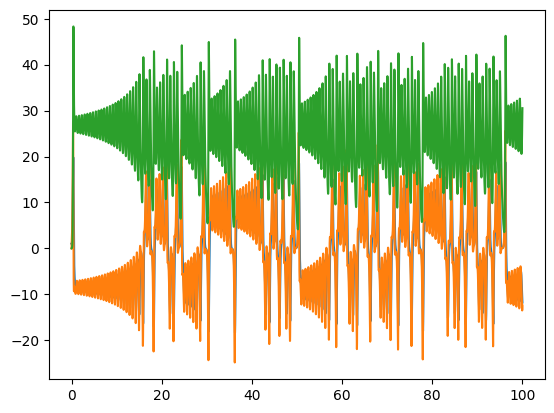

In [ ]:
plt.plot(sol.t,de.transpose(de.stack(sol.u)))
plt.show()

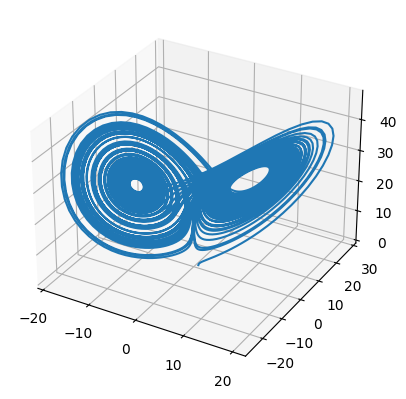

In [ ]:
us = de.stack(sol.u)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(us[0,:],us[1,:],us[2,:])
plt.show()

## Setting up the GPU Solves

Now let's setup the GPU solves. Earlier we used `diffeqpy.install_cuda()` and `from diffeqpy import cuda` to install import CUDA. diffeqpy supports many different GPU backends, from AMD GPUs, Intel's oneAPI, and Apple's Metal GPUs. However, Google Collab only supports NVIDIA CUDA GPUs, and thus we will demonstrate this with CUDA. Here we will demonstrate just the CUDA backend. However, everything for the other backends is the same, with the only difference being the backend choice. This can be swapped as follows:

- `from diffeqpy import cuda` with `cuda.CUDABackend` for NVIDIA GPUs via CUDA
- `from diffeqpy import amdgpu` with `amdgpu.AMDGPUBackend` for AMD GPUs
- `from diffeqpy import oneapi` with `oneapi.oneAPIBackend` for Intel's oneAPI GPUs
- `from diffeqpy import metal` with `metal.MetalBackend` for Apple's Metal GPUs (on M-series processors)

## Using the Ensemble Interface for GPUs

To use the GPU solvers, we need to setup the [DiffEq ensemble interface](https://docs.sciml.ai/DiffEqDocs/stable/features/ensemble/). This looks as follows:

In [ ]:
import random
def prob_func(prob,i,rep):
  de.remake(prob,u0=[random.uniform(0, 1)*u0[i] for i in range(0,3)],
            p=[random.uniform(0, 1)*p[i] for i in range(0,3)])

ensembleprob = de.EnsembleProblem(fast_prob, safetycopy=False)

and with that we can use the `EnsembleGPUKernel` to solve the system on GPUs:

In [ ]:
sol = de.solve(ensembleprob,cuda.GPUTsit5(),cuda.EnsembleGPUKernel(cuda.CUDABackend()),trajectories=10000,saveat=0.01)

## Performance Benchmarks against Python's SciPy

So okay, Python has SciPy as a package for solving ODEs. How does it compare to these optimized GPU solvers? Let's pit them against each other to find out. The test code is as follows:

In [ ]:
import timeit

def time_func():
    sol = de.solve(ensembleprob,cuda.GPUTsit5(),cuda.EnsembleGPUKernel(cuda.CUDABackend()),trajectories=10000,saveat=1.0)

timeit.Timer(time_func).timeit(number=1)

0.25621847999991587

In [ ]:
import numpy as np
from scipy.integrate import odeint

def lorenz(state, t, sigma, beta, rho):
    x, y, z = state

    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z

    return [dx, dy, dz]

sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0
p = (sigma, beta, rho)
y0 = [1.0, 1.0, 1.0]

t = np.arange(0.0, 100.0, 1.0)
result = odeint(lorenz, y0, t, p)

In [ ]:
import timeit
def time_func():
    for itr in range(1, 10001):
        result = odeint(lorenz, y0, t, p)

timeit.Timer(time_func).timeit(number=1)

810.1913794240004

That's 1350x faster than SciPy!

Now the nice thing with GPUs is that they can keep scaling to larger systems. While we cannot run 1 million solves with deSolve due to it taking too long, it's easy to do on our GPU with diffeqr:

In [ ]:
def time_func():
    sol = de.solve(ensembleprob,cuda.GPUTsit5(),cuda.EnsembleGPUKernel(cuda.CUDABackend()),trajectories=1000000,saveat=1.0)

timeit.Timer(time_func).timeit(number=1)

30.184968747000312

And there you go, massive ODE solver scaling! Solving 1 million ODEs about 33x faster than SciPy solves 10,000!

## What about Jax?

Jax is supposed to be a fast thing on GPUs in Python. However, [benchmarks demonstrate that this does not quite hold for its ODE support](https://arxiv.org/abs/2304.06835). So while using GPUs in Julia does incur overhead, the difference from Jax is large enough that we can still demonstrate a performance when measuered from Python. Let's install and setup Jax:

In [ ]:
!pip install jax
!pip install equinox
!pip install diffrax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
import time
import diffrax
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import os
import timeit
import sys

from jax.lib import xla_bridge
print("Working on :", xla_bridge.get_backend().platform)

# %%
# Defining the Lorenz Problem
class Lorenz(eqx.Module):
    k1: float

    def __call__(self, t, y, args):
        f0 = 10.0*(y[1] - y[0])
        f1 = self.k1 * y[0] - y[1] - y[0] * y[2]
        f2 = y[0] * y[1] - (8/3)*y[2]
        return jnp.stack([f0, f1, f2])

# %%
# Repeat the same for adaptive time-stepping
@jax.jit
def main(k1):
    lorenz = Lorenz(k1)
    terms = diffrax.ODETerm(lorenz)
    t0 = 0.0
    t1 = 100.0
    y0 = jnp.array([1.0, 0.0, 0.0])
    dt0 = 0.001
    solver = diffrax.Tsit5()
    saveat = diffrax.SaveAt(ts = jnp.arange(0.0, 100.1, step = 1.0))
    stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
    sol = diffrax.diffeqsolve(
        terms,
        solver,
        t0,
        t1,
        dt0,
        y0,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
        max_steps = 100000,
    )
    return sol

# %%
import timeit

Working on : gpu


Now let's time the Jax solve:

In [ ]:
params = jnp.repeat(28.0, 100000)

In [ ]:
res = timeit.repeat(lambda: jax.vmap(main)(params),repeat = 5,number = 1)

In [ ]:
res

[26.01135885000076,
 21.08534950899957,
 20.78672267299953,
 22.0426537379999,
 21.06144375799977]

Versus:

In [ ]:
def time_func():
    sol = de.solve(ensembleprob,cuda.GPUTsit5(),
                   cuda.EnsembleGPUKernel(cuda.CUDABackend()),
                   abstol=1e-8,reltol=1e-8,
                   trajectories=100000,saveat=1.0)

timeit.Timer(time_func).timeit(number=1)

1.9471062009997695

Thus even with the extra overhead, it's still about an order of magnitude faster than Jax to solve using the Julia ODE solvers!

To remove this overhead, see the [lower level API](https://docs.sciml.ai/DiffEqGPU/stable/tutorials/lower_level_api/).

## Conclusion

[diffeqpy](https://github.com/SciML/diffeqpy) is a high-performance system for solving many different types of differential equation models. Not only is it flexible and fast, but it's also able to make use of modern hardware, including not just NVIDIA GPUs but also Intel, AMD, and Mac GPUs. If you really need performance, give diffeqr a try!

Finally, the performance shown here is only a fraction of the performance seen from Julia. If the absolute max performance is required, one should make use of [DiffEqGPU.jl](https://docs.sciml.ai/DiffEqGPU/stable/) from Julia (the system on which diffeqpy's GPU support is built!). This can generally pull out another 50x in performance.